# [オンライン開催]PyTorchで学ぶ深層学習入門第3回


## Section1. 最適化と初期化について
ニューラルネットワークの最適化と初期化の手法をみていきます。  
ニューラルネットワークの深さを増すとき、私たちが直面するさまざまな課題があります。最も重要なことは、ネットワークを介して安定した勾配の流れが必要であることです。そうしないと、勾配の消失または爆発が発生する可能性があります。これが、初期化と最適化という概念を詳しく見ていく理由です。

ノートブックの前半では、さまざまな初期化手法を確認し、最も単純な初期化から、現在非常に深いネットワークで使用されている手法まで、段階を追って説明します。後半では、オプティマイザ SGD、SGD with Momentum、および Adam を比較する最適化に焦点を当てます。

まずは各種標準ライブラリや必要なライブラリをインポートしていきましょう。

In [ ]:
## 標準ライブラリのインストール
import os
import json
import math
import numpy as np 

In [ ]:
## 可視化ライブラリのインストール
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # 保存用
import seaborn as sns
sns.set()

In [ ]:
## プロセス可視化用
from tqdm.notebook import tqdm

In [ ]:
## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

set_seed 関数と、パス変数 DATASET_PATH および CHECKPOINT_PATH を使用します。必要に応じてパスを設定してください

In [ ]:
# データセット　ダウンロード用のフォルダパス
DATASET_PATH = "../data"
# 学習済みモデルの保存先フォルダパス
CHECKPOINT_PATH = "../saved_models/vol3"

# 乱数設定用のパス
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available(): # GPU用
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

Using device cuda:0


ノートブックの最後の部分では、3 つの異なるオプティマイザーを使用してモデルをトレーニングします。これらの事前学習済みモデルは、以下からダウンロードできます。

In [ ]:
set_seed(42)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

## Section1-1. 準備
前回と同様に、ネットワークを定義します。
FashionMNIST データセットをロードすることから始めます。

In [ ]:
from torchvision.datasets import FashionMNIST
from torchvision import transforms

# 各画像に適用される変換 => 入力データをテンソルにし、正規化
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.2861,), (0.3530,))
                               ])

# データセットの読み込み 学習用データと検証用データ
train_dataset = FashionMNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# テスト用データの読み込み
test_set = FashionMNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

# データローダー
# PyTorchでは、モデルを学習するときに必要
train_loader = data.DataLoader(train_set, batch_size=1024, shuffle=True, drop_last=False)
val_loader = data.DataLoader(val_set, batch_size=1024, shuffle=False, drop_last=False)
test_loader = data.DataLoader(test_set, batch_size=1024, shuffle=False, drop_last=False)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



前回と異なり、正規化変換 transforms.Normalize のパラメーターを変更しました。正規化は、ピクセル全体で 0 の期待平均と 1 の標準偏差を与えるように設計されています。これは、このあと説明する初期化にに特に関連するため、ここで変更します。ほとんどの分類タスクでは、両方の正規化手法 (-1 と 1 の間、または平均 0 と stddev 1) が適しています。元の画像の平均と標準偏差を決定することにより、正規化パラメーターを計算できます。

In [ ]:
print("Mean", (train_dataset.data.float() / 255.0).mean().item())
print("Std", (train_dataset.data.float() / 255.0).std().item())

Mean 0.28604060411453247
Std 0.3530242443084717


正規化されているかどうか、確認

In [ ]:
imgs, _ = next(iter(train_loader))
print(f"Mean: {imgs.mean().item():5.3f}")
print(f"Standard deviation: {imgs.std().item():5.3f}")
print(f"Maximum: {imgs.max().item():5.3f}")
print(f"Minimum: {imgs.min().item():5.3f}")

Mean: 0.020
Standard deviation: 1.011
Maximum: 2.022
Minimum: -0.810


線形ニューラルネットワークを作成します。前回と同様の設定を再利用します。

In [ ]:
class BaseNetwork(nn.Module):
    
    def __init__(self, act_fn, input_size=784, num_classes=10, hidden_sizes=[512, 256, 256, 128]):
        """
        Inputs:
            act_fn - 活性化関数の指定
            input_size - 入力データのピクセルサイズ
            num_classes - 分類したい個数
            hidden_sizes - 隠れ層のサイズを指定する整数のリスト
        """
        super().__init__()
        
        # 指定された隠しサイズに基づいてネットワークを作成
        layers = []
        layer_sizes = [input_size] + hidden_sizes
        for layer_index in range(1, len(layer_sizes)):
            layers += [nn.Linear(layer_sizes[layer_index-1], layer_sizes[layer_index]),
                       act_fn]
        layers += [nn.Linear(layer_sizes[-1], num_classes)]
        self.layers = nn.ModuleList(layers) # モジュールのリストをサブモジュールとして登録
        
        self.config = {"act_fn": act_fn.__class__.__name__, "input_size": input_size, "num_classes": num_classes, "hidden_sizes": hidden_sizes} 
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        for l in self.layers:
            x = l(x)
        return x

活性化関数については、自分自身を実装する代わりに、PyTorch の torch.nn ライブラリを利用します。ただし、Identity 活性化関数も定義します。この関数は、ネットワークのモデリング機能を大幅に制限しますが、初期化に関する説明の最初のステップで使用します (簡単にするため)。

In [ ]:
class Identity(nn.Module):
    def forward(self, x):
        return x
    
act_fn_by_name = {
    "tanh": nn.Tanh,
    "relu": nn.ReLU,
    "identity": Identity
}

最後に、今回可視化するために使用する関数を定義します。これらの関数は、(1) ネットワーク内の重み/パラメーター分布の視覚化、(2) 異なるレイヤーのパラメーターが受け取る勾配の視覚化、および (3) アクティベーション、つまり線形レイヤーの出力を可視化します。詳細なコードは重要ではありませんが、興味があれば詳しく調べてみてください。

In [ ]:
def plot_dists(val_dict, color="C0", xlabel=None, stat="count", use_kde=True):
    columns = len(val_dict)
    fig, ax = plt.subplots(1, columns, figsize=(columns*3, 2.5))
    fig_index = 0
    for key in sorted(val_dict.keys()):
        key_ax = ax[fig_index%columns]
        sns.histplot(val_dict[key], ax=key_ax, color=color, bins=50, stat=stat,
                     kde=use_kde and ((val_dict[key].max()-val_dict[key].min())>1e-8)) # Only plot kde if there is variance
        key_ax.set_title(f"{key} " + (r"(%i $\to$ %i)" % (val_dict[key].shape[1], val_dict[key].shape[0]) if len(val_dict[key].shape)>1 else ""))
        if xlabel is not None:
            key_ax.set_xlabel(xlabel)
        fig_index += 1
    fig.subplots_adjust(wspace=0.4)
    return fig

In [ ]:
def visualize_weight_distribution(model, color="C0"):
    weights = {}
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            continue
        key_name = f"Layer {name.split('.')[1]}"
        weights[key_name] = param.detach().view(-1).cpu().numpy()
    
    ## 可視化
    fig = plot_dists(weights, color=color, xlabel="Weight vals")
    fig.suptitle("Weight distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close() 

In [ ]:
def visualize_gradients(model, color="C0", print_variance=False):
    """
    Inputs:
        net - BaseNetwork のオブジェクト
        color - ヒストグラムを視覚化する色の指定
    """
    model.eval()
    small_loader = data.DataLoader(train_set, batch_size=1024, shuffle=False)
    imgs, labels = next(iter(small_loader))
    imgs, labels = imgs.to(device), labels.to(device)
    
    # 重みの勾配を計算
    model.zero_grad()
    preds = model(imgs)
    loss = F.cross_entropy(preds, labels) # nn.CrossEntropyLoss と同じですが、モジュールではなく関数として定義
    loss.backward()
    # 重みパラメータを制限し、バイアスを除外してプロットの数を減らす（軽量化）
    grads = {name: params.grad.view(-1).cpu().clone().numpy() for name, params in model.named_parameters() if "weight" in name}
    model.zero_grad()
    
    ## 可視化
    fig = plot_dists(grads, color=color, xlabel="Grad magnitude")
    fig.suptitle("Gradient distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close() 
    
    if print_variance:
        for key in sorted(grads.keys()):
            print(f"{key} - Variance: {np.var(grads[key])}")

In [ ]:
def visualize_activations(model, color="C0", print_variance=False):
    model.eval()
    small_loader = data.DataLoader(train_set, batch_size=1024, shuffle=False)
    imgs, labels = next(iter(small_loader))
    imgs, labels = imgs.to(device), labels.to(device)
    
    # 重みの勾配を計算
    feats = imgs.view(imgs.shape[0], -1)
    activations = {}
    with torch.no_grad():
        for layer_index, layer in enumerate(model.layers):
            feats = layer(feats)
            if isinstance(layer, nn.Linear):
                activations[f"Layer {layer_index}"] = feats.view(-1).detach().cpu().numpy()
    
    ## 可視化
    fig = plot_dists(activations, color=color, stat="density", xlabel="Activation vals")
    fig.suptitle("Activation distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close() 
    
    if print_variance:
        for key in sorted(activations.keys()):
            print(f"{key} - Variance: {np.var(activations[key])}")

## Section1-2. 初期化
初期化について始める前に、ニューラルネットワークの初期化のトピックに関するブログが結構あるため(たとえば、deeplearning.ai、またはより数学に焦点を当てたブログ)。今回時間の都合上割愛している諸々の情報についてや、何か不明な点がある場合は、これらのブログをざっと読むことをお勧めします。

ニューラルネットワークを初期化するとき、必要な設計や設定がいくつかあります。まず、出力ニューロンの標準偏差が同様になるように、入力の分散をモデルを通じて最後の層に伝播する必要があります。モデルを深く掘り下げるほど分散が消失する場合、次のレイヤーへの入力は基本的に単一の定数値であるため、モデルを最適化するのがはるかに難しくなります。同様に、分散が増加すると、モデルをより深く設計するほど爆発する (つまり、無限に向かう) 可能性があります。初期化手法で注目する 2 番目のプロパティは、レイヤー間で分散が等しい勾配分布です。最初のレイヤーが最後のレイヤーよりもはるかに小さい勾配を受け取る場合、適切な学習率を選択するのが難しくなります。

適切な方法を見つけるための出発点として、まずは活性化関数のない線形ニューラルネットワークに基づいて、さまざまな初期化を分析します。これを行うのは、初期化がネットワークで使用される特定の活性化関数に依存し、後で特定の選択に合わせて初期化のスキーム・条件を調整できるためです。

In [ ]:
model = BaseNetwork(act_fn=Identity()).to(device)

### Section1-2-1. 定数の初期化
考慮できる最初の初期化は、すべての重みを同じ定数値で初期化することです。直観的には、伝播される勾配がゼロになるため、すべての重みをゼロに設定することはお勧めできません。しかし、すべての重みを 0 よりわずかに大きいか小さい値に設定するとどうなるでしょうか。これらを調べるために、以下のすべてのパラメーターを設定する関数を実装し、勾配を視覚化します。

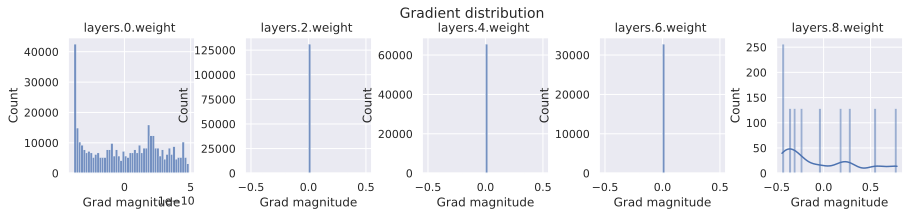

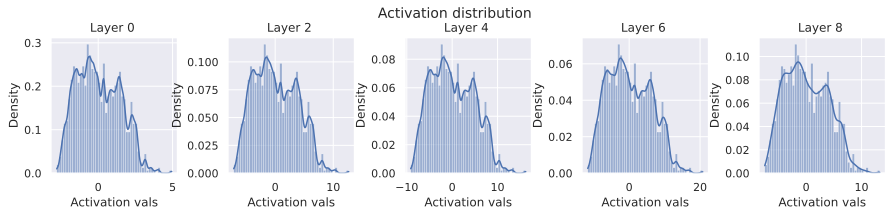

Layer 0 - Variance: 2.0582759380340576
Layer 2 - Variance: 13.489116668701172
Layer 4 - Variance: 22.100570678710938
Layer 6 - Variance: 36.209571838378906
Layer 8 - Variance: 14.831440925598145


In [ ]:
def const_init(model, c=0.0):
    for name, param in model.named_parameters():
        param.data.fill_(c)

const_init(model, c=0.005)
visualize_gradients(model)
visualize_activations(model, print_variance=True)

結果の通り、最初と最後のレイヤーだけがさまざまな勾配分布を持ち、他の 3 つのレイヤーはすべての重みで同じ勾配を持っています (これら値は 0 ではありませんが、多くの場合、ゼロに非常に近い)。同じ値で初期化されたパラメーターの勾配が同じということは、それらのパラメーターの値が常に同じであることを意味します。これにより、学習するための「層」が役に立たなくなり、有効なパラメーター数が 1 に減少します。したがって、ネットワークをトレーニングする際には、定数の初期化を適用することはできません。

## Section1-2-2. 定数の分散
上記の実験から、定数値が機能していないことがわかりました。代わりに、ガウスのような分布からランダムにサンプリングしてパラメーターを初期化するのはどうでしょうか？  
最も直感的な方法は、ネットワーク内のすべての層に使用される 分散を適用することです。以下に実装して、層全体の活性化の分布を視覚化しましょう。

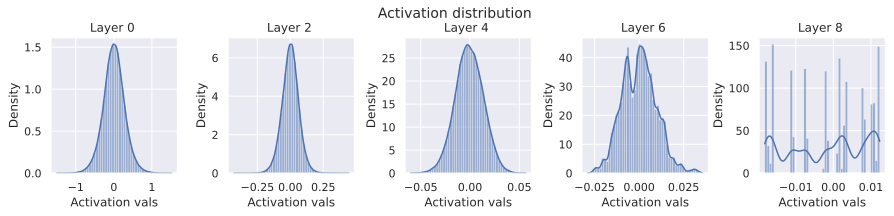

Layer 0 - Variance: 0.07794515788555145
Layer 2 - Variance: 0.004074736498296261
Layer 4 - Variance: 0.0002034862118307501
Layer 6 - Variance: 9.358522220281884e-05
Layer 8 - Variance: 0.00010496507456991822


In [ ]:
def var_init(model, std=0.01):
    for name, param in model.named_parameters():
        param.data.normal_(std=std)
        
var_init(model, std=0.01)
visualize_activations(model, print_variance=True)

活性化の分散は、層全体でますます小さくなり、最後の層ではほとんどなくなります。次に、より強い標準偏差を適用してみます。

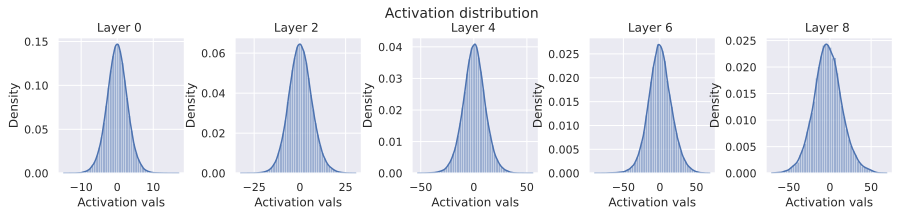

Layer 0 - Variance: 8.188533782958984
Layer 2 - Variance: 41.06459426879883
Layer 4 - Variance: 109.57990264892578
Layer 6 - Variance: 257.75146484375
Layer 8 - Variance: 298.45294189453125


In [ ]:
var_init(model, std=0.1)
visualize_activations(model, print_variance=True)

標準偏差が強いほど(大きいほど)、活性化の分布が発散・増加する可能性があります。特定の標準偏差値をいじることはできますが、層全体で「程よい」活性化分布を与えつつ、最適なモデルを見つけるのは難しいでしょう。全てのサイズや層の数を変更すると、もう一度検索する必要があって、効率的でなく推奨されません。

### Section1-2-3. 適切な初期化の値を見つける方法
上記の実験から、分布から重みをサンプリングする必要があることがわかりましたが、どれが正確か、どれが正解かはわかりません。次のステップとして、活性化分布の観点から最適な初期化を見つけられないか探ってみましょう。次の 2つの条件があります。


1.   活性化の平均はゼロでなければなりません
2.   活性化の分散は、すべての層で同じものにする必要があります


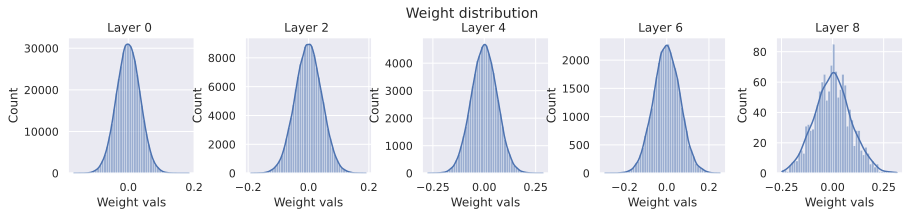

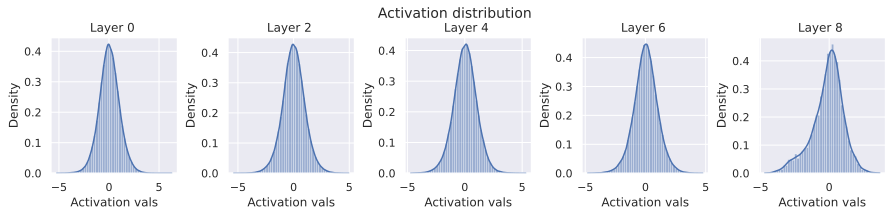

Layer 0 - Variance: 1.0240916013717651
Layer 2 - Variance: 1.0060017108917236
Layer 4 - Variance: 1.011448860168457
Layer 6 - Variance: 0.9635002017021179
Layer 8 - Variance: 1.29520583152771


In [ ]:
def equal_var_init(model):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            param.data.normal_(std=1.0/math.sqrt(param.shape[1]))
        
equal_var_init(model)
visualize_weight_distribution(model)
visualize_activations(model, print_variance=True)

予想どおり、分散は層全体で実際に一定のままです。初期化は正規分布に限定されませんが、平均が 0 で分散が初期化に一様分布が使用されていることがよくあります。正規分布の代わりに一様分布を使用する利点は、非常に大きな重みまたは小さな重みを初期化する可能性を排除できることです。

活性化の分散に加えて、安定させたい別の分散は、勾配です。これにより、深いネットワークの安定した最適化が保証されます。これら詳しい実験について、Glorot と Bengio (2010) は両方の値の調和平均を使用することを提案しました。これにより、一般的によく知られている `Xavier` の初期化が行われます。

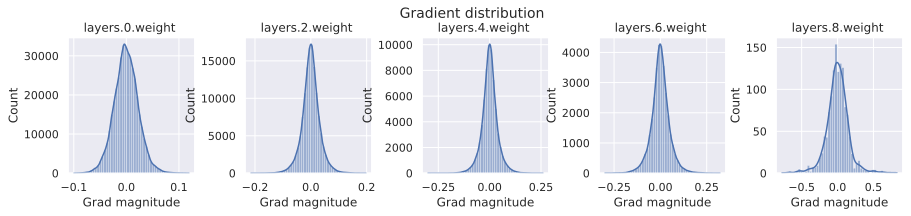

layers.0.weight - Variance: 0.0005261834594421089
layers.2.weight - Variance: 0.001026435405947268
layers.4.weight - Variance: 0.0014798258198425174
layers.6.weight - Variance: 0.002524042036384344
layers.8.weight - Variance: 0.024714577943086624


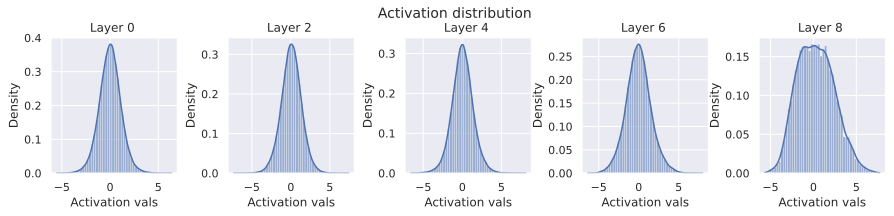

Layer 0 - Variance: 1.265830397605896
Layer 2 - Variance: 1.6661193370819092
Layer 4 - Variance: 1.847960114479065
Layer 6 - Variance: 2.421503782272339
Layer 8 - Variance: 4.538285732269287


In [ ]:
def xavier_init(model):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            bound = math.sqrt(6)/math.sqrt(param.shape[0]+param.shape[1])
            param.data.uniform_(-bound, bound)
        
xavier_init(model)
visualize_gradients(model, print_variance=True)
visualize_activations(model, print_variance=True)

Xavier の初期化により、勾配と活性化の分散のバランスが取れていることがわかります。出力層の大幅に高い分散は、入力次元と出力次元の大きな違いによるものであることに注意してください。  
ただし、今ここでは活性化関数は線形であると想定しています。では、非線形性を追加するとどうなるでしょうか？tanh ベースのネットワークでは、トレーニングの最初のステップで値が小さい場合、
 線形関数として機能するため、計算を調整する必要はありません。これが本当かどうかを確認します。

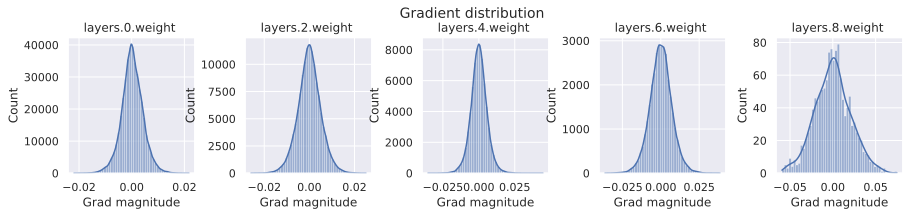

layers.0.weight - Variance: 1.6520496501470916e-05
layers.2.weight - Variance: 2.594707257230766e-05
layers.4.weight - Variance: 3.2040345104178414e-05
layers.6.weight - Variance: 5.196761412662454e-05
layers.8.weight - Variance: 0.0004421582561917603


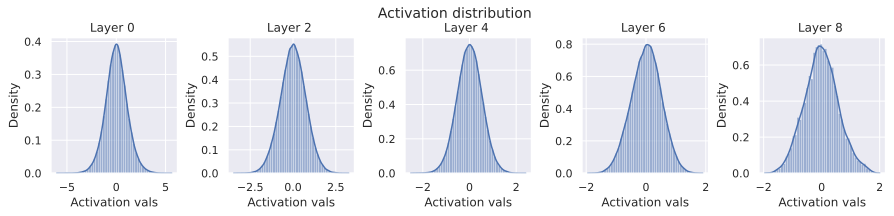

Layer 0 - Variance: 1.1967560052871704
Layer 2 - Variance: 0.546739399433136
Layer 4 - Variance: 0.2838296890258789
Layer 6 - Variance: 0.24751484394073486
Layer 8 - Variance: 0.33651798963546753


In [ ]:
model = BaseNetwork(act_fn=nn.Tanh()).to(device)
xavier_init(model)
visualize_gradients(model, print_variance=True)
visualize_activations(model, print_variance=True)

分散は深さとともに減少しますが、活性化分布が低い値により集中するようになることは明らかです。したがって、さらに深く行けば、分散は 0.25 前後で安定します。したがって、Xavier の初期化は Tanh ネットワークでうまく機能すると結論付けることができます。  
では、ReLU ネットワークはどうでしょうか？ここでは、非線形性が小さな値に対して線形になるという以前の仮定を採用することはできません。 ReLU 関数は、入力の期待値もゼロにならないように、(期待値として) 入力の半分を 0 に設定してみます。  

Kaiming の初期化を利用します (He, K. et al. (2015) を参照)。   
Kaiming の初期化では、入力サイズと出力サイズの間の調和平均を適用しないことに注意してください。  

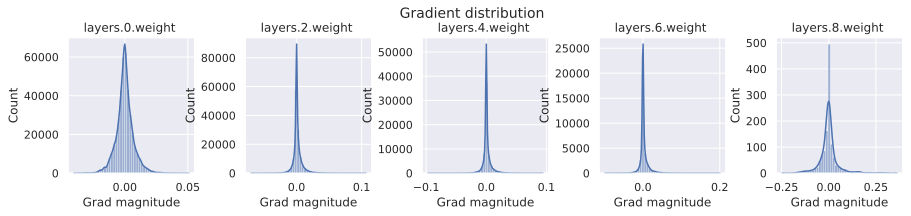

layers.0.weight - Variance: 4.81999886687845e-05
layers.2.weight - Variance: 5.256031363387592e-05
layers.4.weight - Variance: 5.5228931159945205e-05
layers.6.weight - Variance: 0.0001343417097814381
layers.8.weight - Variance: 0.00257961917668581


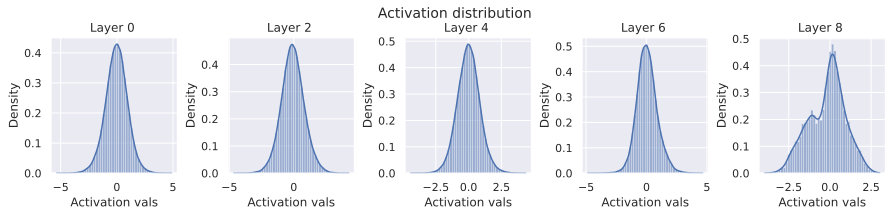

Layer 0 - Variance: 0.9595181941986084
Layer 2 - Variance: 0.7935568690299988
Layer 4 - Variance: 0.7345138192176819
Layer 6 - Variance: 0.7212525606155396
Layer 8 - Variance: 1.2326970100402832


In [ ]:
def kaiming_init(model):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        elif name.startswith("layers.0"): # 入力層に、その入力に ReLU が適用されていない場合
            param.data.normal_(0, 1/math.sqrt(param.shape[1]))
        else:
            param.data.normal_(0, math.sqrt(2)/math.sqrt(param.shape[1]))

model = BaseNetwork(act_fn=nn.ReLU()).to(device)
kaiming_init(model)
visualize_gradients(model, print_variance=True)
visualize_activations(model, print_variance=True)

分散はレイヤー全体で安定しています。   
Kaiming の初期化は、ReLU ベースのネットワークでも実際にうまく機能すると結論付けることができます。 Leaky-ReLU などの場合、係数を微調整する必要があるため、ややこしいです。  

PyTorch は、多くの活性化関数に対してこれら係数を計算する関数を提供します。  
詳しくは `torch.nn.init.calculate_gain` を調べてみてください。

## Section2. 最適化
初期化に加えて、適切な最適化アルゴリズムを選択することは、ディープニューラルネットワークにとって重要な選択となる場合があります。それらを詳しく見ていく前に、モデルをトレーニングするためのコードを定義する必要があります。次のコードは、ほぼ前回のものをコピーしたものであり、必要に応じて若干カスタムしています。

In [ ]:
def _get_config_file(model_path, model_name):
    return os.path.join(model_path, model_name + ".config")

In [ ]:
def _get_model_file(model_path, model_name):
    return os.path.join(model_path, model_name + ".tar")

In [ ]:
def _get_result_file(model_path, model_name):
    return os.path.join(model_path, model_name + "_results.json")

In [ ]:
def load_model(model_path, model_name, net=None):
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    assert os.path.isfile(config_file), f"Could not find the config file \"{config_file}\". Are you sure this is the correct path and you have your model config stored here?"
    assert os.path.isfile(model_file), f"Could not find the model file \"{model_file}\". Are you sure this is the correct path and you have your model stored here?"
    with open(config_file, "r") as f:
        config_dict = json.load(f)
    if net is None:
        act_fn_name = config_dict["act_fn"].pop("name").lower()
        assert act_fn_name in act_fn_by_name, f"Unknown activation function \"{act_fn_name}\". Please add it to the \"act_fn_by_name\" dict."
        act_fn = act_fn_by_name[act_fn_name]()
        net = BaseNetwork(act_fn=act_fn, **config_dict)
    net.load_state_dict(torch.load(model_file))
    return net

In [ ]:
def save_model(model, model_path, model_name):
    config_dict = model.config
    os.makedirs(model_path, exist_ok=True)
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    with open(config_file, "w") as f:
        json.dump(config_dict, f)
    torch.save(model.state_dict(), model_file)

In [ ]:
def train_model(net, model_name, optim_func, max_epochs=50, batch_size=256, overwrite=False):
    """
    FashionMNISTをデータとしたモデルの学習
    
    Inputs:
        net - BaseNetworkオブジェクト
        model_name - モデル名
        max_epochs - エポック数の指定
        patience - 学習の早期切り上げの目安
        batch_size - バッチサイズの指定
        overwrite - 上書き指定、True の場合、上書　それ以外の場合は、学習をスキップ
    """
    file_exists = os.path.isfile(_get_model_file(CHECKPOINT_PATH, model_name))
    if file_exists and not overwrite:
        print(f"Model file of \"{model_name}\" already exists. Skipping training...")
        with open(_get_result_file(CHECKPOINT_PATH, model_name), "r") as f:
            results = json.load(f)
    else:
        if file_exists:
            print("Model file exists, but will be overwritten...")
            
        # オプティマイザー、ロス、データローダーの定義
        optimizer =  optim_func(net.parameters())
        loss_module = nn.CrossEntropyLoss()
        train_loader_local = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)
    
        results = None
        val_scores = []
        train_losses, train_scores = [], []
        best_val_epoch = -1
        for epoch in range(max_epochs):
            ############
            # 学習 #
            ############
            net.train()
            true_preds, count = 0., 0
            t = tqdm(train_loader_local, leave=False)
            for imgs, labels in t:
                imgs, labels = imgs.to(device), labels.to(device)
                optimizer.zero_grad()
                preds = net(imgs)
                loss = loss_module(preds, labels)
                loss.backward()
                optimizer.step()
                # 学習している途中途中の統計量
                true_preds += (preds.argmax(dim=-1) == labels).sum().item()
                count += labels.shape[0]
                t.set_description(f"Epoch {epoch+1}: loss={loss.item():4.2f}")
                train_losses.append(loss.item())
            train_acc = true_preds / count
            train_scores.append(train_acc)

            ##############
            # バリデーション #
            ##############
            val_acc = test_model(net, val_loader)
            val_scores.append(val_acc)
            print(f"[Epoch {epoch+1:2d}] Training accuracy: {train_acc*100.0:05.2f}%, Validation accuracy: {val_acc*100.0:05.2f}%")

            if len(val_scores) == 1 or val_acc > val_scores[best_val_epoch]:
                print("\t   (New best performance, saving model...)")
                save_model(net, CHECKPOINT_PATH, model_name)
                best_val_epoch = epoch
    
    if results is None:
        load_model(CHECKPOINT_PATH, model_name, net=net)
        test_acc = test_model(net, test_loader)
        results = {"test_acc": test_acc, "val_scores": val_scores, "train_losses": train_losses, "train_scores": train_scores}
        with open(_get_result_file(CHECKPOINT_PATH, model_name), "w") as f:
            json.dump(results, f)
            
    # 学習のプロセスを精度で可視化
    sns.set()
    plt.plot([i for i in range(1,len(results["train_scores"])+1)], results["train_scores"], label="Train")
    plt.plot([i for i in range(1,len(results["val_scores"])+1)], results["val_scores"], label="Val")
    plt.xlabel("Epochs")
    plt.ylabel("Validation accuracy")
    plt.ylim(min(results["val_scores"]), max(results["train_scores"])*1.01)
    plt.title(f"Validation performance of {model_name}")
    plt.legend()
    plt.show()
    plt.close()
    
    print((f" Test accuracy: {results['test_acc']*100.0:4.2f}% ").center(50, "=")+"\n")
    return results

In [ ]:
def test_model(net, data_loader):
    """
    Test a model on a specified dataset.
    
    Inputs:
        net - BaseNetwork のモデル
        data_loader - データローダー化したデータセット
    """
    net.eval()
    true_preds, count = 0., 0
    for imgs, labels in data_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        with torch.no_grad():
            preds = net(imgs).argmax(dim=-1)
            true_preds += (preds == labels).sum().item()
            count += labels.shape[0]
    test_acc = true_preds / count
    return test_acc 

まず、オプティマイザーが実際に何をするかを理解する必要があります。オプティマイザーは、勾配が与えられたネットワークのパラメーターを更新するという役割があります。  

以下の PyTorch でオプティマイザのテンプレートを定義できます。モデルのパラメータと学習率を入力として取ります。関数 `zero_grad` は、すべてのパラメーターの勾配をゼロに設定します。これは、`loss.backward() `を呼び出す前に行う必要があります。最後に、`step()` 関数は、勾配に基づいてすべての重みを更新するようオプティマイザに指示します。テンプレートは次のように設定されています。

In [ ]:
class OptimizerTemplate:
    
    def __init__(self, params, lr):
        self.params = list(params)
        self.lr = lr
        
    def zero_grad(self):
        ## すべてのパラメータの勾配をゼロに設定
        for p in self.params:
            if p.grad is not None:
                p.grad.detach_() # オプティマイザー内の勾配を再設定
                p.grad.zero_()
    
    @torch.no_grad()
    def step(self):
        ## すべてのパラメーターに更新ステップを適用
        for p in self.params:
            if p.grad is None: # 勾配がない場合、パラメーターをスキップ
                continue
            self.update_param(p)
            
    def update_param(self, p):
        # オプティマイザ固有のクラスに実装
        raise NotImplementedError

最初に実装するオプティマイザーは、標準の確率的勾配降下法 (SGD) です。 SGD は、次の式を使用してパラメータを更新します。

In [ ]:
class SGD(OptimizerTemplate):
    
    def __init__(self, params, lr):
        super().__init__(params, lr)
        
    def update_param(self, p):
        p_update = -self.lr * p.grad
        p.add_(p_update) # 更新 => メモリを節約し、グラフを作成

現在のものを含むすべての過去の勾配の指数平均によって更新の勾配を置き換える、モーメンタムという概念があります。

In [ ]:
class SGDMomentum(OptimizerTemplate):
    
    def __init__(self, params, lr, momentum=0.0):
        super().__init__(params, lr)
        self.momentum = momentum # 上記の式の beta_1 に該当
        self.param_momentum = {p: torch.zeros_like(p.data) for p in self.params} # 辞書として m_t に蓄積
        
    def update_param(self, p):
        self.param_momentum[p] = (1 - self.momentum) * p.grad + self.momentum * self.param_momentum[p]
        p_update = -self.lr * self.param_momentum[p]
        p.add_(p_update)

次に、Adam です。
モーメンタムというアイデアを、勾配の二乗の指数平均、つまり勾配ノルムに基づく適応学習率と組み合わせます。さらに、最初の反復のモーメンタムと適応学習率のバイアス補正を追加します。

`Epsilon` は、非常に小さな勾配ノルムの数値安定性を向上させるために使用される小さな定数です。適応学習率は学習率ハイパーパラメータに取って代わるものではないことに注意してください。むしろ追加の要因として機能し、さまざまなパラメーターの勾配が同様のノルムを持つようにします。

In [ ]:
class Adam(OptimizerTemplate):
    
    def __init__(self, params, lr, beta1=0.9, beta2=0.999, eps=1e-8):
        super().__init__(params, lr)
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.param_step = {p: 0 for p in self.params} # バイアス補正用の各パラメータの「t」を記憶
        self.param_momentum = {p: torch.zeros_like(p.data) for p in self.params}
        self.param_2nd_momentum = {p: torch.zeros_like(p.data) for p in self.params}
        
    def update_param(self, p):
        self.param_step[p] += 1
        
        self.param_momentum[p] = (1 - self.beta1) * p.grad + self.beta1 * self.param_momentum[p]
        self.param_2nd_momentum[p] = (1 - self.beta2) * (p.grad)**2 + self.beta2 * self.param_2nd_momentum[p]
        
        bias_correction_1 = 1 - self.beta1 ** self.param_step[p]
        bias_correction_2 = 1 - self.beta2 ** self.param_step[p]
        
        p_2nd_mom = self.param_2nd_momentum[p] / bias_correction_2
        p_mom = self.param_momentum[p] / bias_correction_1
        p_lr = self.lr / (torch.sqrt(p_2nd_mom) + self.eps)
        p_update = -p_lr * p_mom
        
        p.add_(p_update)

In [ ]:
base_model = BaseNetwork(act_fn=nn.ReLU(), hidden_sizes=[512,256,256,128])
kaiming_init(base_model)

### Section2-1. モデル トレーニングしてオプティマイザーを比較する
3 つのオプティマイザー (SGD、モーメンタム付き SGD、Adam) を実装したら、それらの分析と比較を開始できます。まず、FashionMNIST データセットでニューラル ネットワークをどれだけ最適化できるかをテストします。再び線形ネットワークを使用します。今回は、ReLU 関数と `kaiming` 初期化を使用します。これは、先ほどの実験で ReLU ベースのネットワークでうまく機能することがわかっています。モデルはこのタスクに対して過度にパラメーター化されていることに注意してください。また、はるかに小さいネットワーク (たとえば、100、100、100) で同様のパフォーマンスを達成できます。オプティマイザーがディープニューラルネットワークをどれだけうまくトレーニングできるかみてみましょう。  

公正な比較のために、以下の 3 つのオプティマイザーを使用して、まったく同じモデルを同じシードでトレーニングします。必要に応じてハイパーパラメータを自由に変更してください (ただし、変更した場合は、モデルをトレーニングする必要があります)。

  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  1] Training accuracy: 78.02%, Validation accuracy: 85.14%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  2] Training accuracy: 85.57%, Validation accuracy: 85.83%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  3] Training accuracy: 87.39%, Validation accuracy: 85.53%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  4] Training accuracy: 88.45%, Validation accuracy: 87.62%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  5] Training accuracy: 89.32%, Validation accuracy: 88.29%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  6] Training accuracy: 90.09%, Validation accuracy: 87.44%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  7] Training accuracy: 90.73%, Validation accuracy: 88.23%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  8] Training accuracy: 91.24%, Validation accuracy: 87.79%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  9] Training accuracy: 91.76%, Validation accuracy: 88.79%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 10] Training accuracy: 92.33%, Validation accuracy: 88.22%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 11] Training accuracy: 92.61%, Validation accuracy: 88.25%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 12] Training accuracy: 93.25%, Validation accuracy: 88.97%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 13] Training accuracy: 93.10%, Validation accuracy: 87.85%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 14] Training accuracy: 93.70%, Validation accuracy: 89.13%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 15] Training accuracy: 94.14%, Validation accuracy: 89.38%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 16] Training accuracy: 94.57%, Validation accuracy: 89.28%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 17] Training accuracy: 94.86%, Validation accuracy: 88.86%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 18] Training accuracy: 95.14%, Validation accuracy: 89.25%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 19] Training accuracy: 95.13%, Validation accuracy: 89.03%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 20] Training accuracy: 95.61%, Validation accuracy: 89.08%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 21] Training accuracy: 96.10%, Validation accuracy: 88.02%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 22] Training accuracy: 96.09%, Validation accuracy: 89.60%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 23] Training accuracy: 96.26%, Validation accuracy: 89.02%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 24] Training accuracy: 95.62%, Validation accuracy: 88.77%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 25] Training accuracy: 96.58%, Validation accuracy: 89.60%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 26] Training accuracy: 97.02%, Validation accuracy: 88.82%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 27] Training accuracy: 97.21%, Validation accuracy: 89.47%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 28] Training accuracy: 97.24%, Validation accuracy: 89.36%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 29] Training accuracy: 97.54%, Validation accuracy: 88.82%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 30] Training accuracy: 97.61%, Validation accuracy: 85.77%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 31] Training accuracy: 97.77%, Validation accuracy: 89.68%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 32] Training accuracy: 97.39%, Validation accuracy: 89.35%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 33] Training accuracy: 98.08%, Validation accuracy: 88.96%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 34] Training accuracy: 98.27%, Validation accuracy: 89.66%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 35] Training accuracy: 97.97%, Validation accuracy: 89.54%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 36] Training accuracy: 98.33%, Validation accuracy: 88.87%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 37] Training accuracy: 98.73%, Validation accuracy: 89.76%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 38] Training accuracy: 97.67%, Validation accuracy: 87.44%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 39] Training accuracy: 98.65%, Validation accuracy: 89.74%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 40] Training accuracy: 99.11%, Validation accuracy: 89.62%


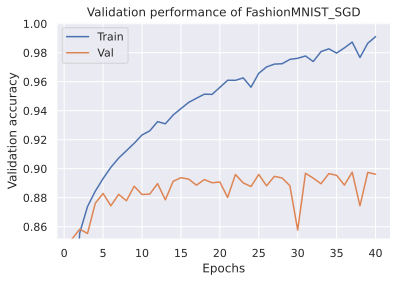

============= Test accuracy: 89.05% ==============



In [ ]:
import copy
SGD_model = copy.deepcopy(base_model).to(device)
SGD_results = train_model(SGD_model, "FashionMNIST_SGD", 
                          lambda params: SGD(params, lr=1e-1), 
                          max_epochs=40, batch_size=256)

  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  1] Training accuracy: 79.92%, Validation accuracy: 85.13%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  2] Training accuracy: 86.45%, Validation accuracy: 86.46%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  3] Training accuracy: 87.93%, Validation accuracy: 86.56%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  4] Training accuracy: 88.87%, Validation accuracy: 87.84%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  5] Training accuracy: 89.82%, Validation accuracy: 88.41%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  6] Training accuracy: 90.44%, Validation accuracy: 88.59%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  7] Training accuracy: 91.33%, Validation accuracy: 88.39%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  8] Training accuracy: 91.88%, Validation accuracy: 89.23%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  9] Training accuracy: 92.50%, Validation accuracy: 88.54%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 10] Training accuracy: 92.74%, Validation accuracy: 89.49%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 11] Training accuracy: 93.27%, Validation accuracy: 89.06%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 12] Training accuracy: 93.52%, Validation accuracy: 88.97%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 13] Training accuracy: 94.05%, Validation accuracy: 88.78%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 14] Training accuracy: 94.42%, Validation accuracy: 88.80%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 15] Training accuracy: 94.80%, Validation accuracy: 88.85%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 16] Training accuracy: 95.11%, Validation accuracy: 88.94%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 17] Training accuracy: 95.37%, Validation accuracy: 89.22%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 18] Training accuracy: 95.59%, Validation accuracy: 88.71%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 19] Training accuracy: 96.07%, Validation accuracy: 88.74%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 20] Training accuracy: 96.01%, Validation accuracy: 88.52%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 21] Training accuracy: 96.24%, Validation accuracy: 89.02%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 22] Training accuracy: 96.76%, Validation accuracy: 88.71%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 23] Training accuracy: 96.56%, Validation accuracy: 88.21%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 24] Training accuracy: 96.90%, Validation accuracy: 89.58%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 25] Training accuracy: 97.20%, Validation accuracy: 89.16%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 26] Training accuracy: 97.30%, Validation accuracy: 89.17%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 27] Training accuracy: 97.43%, Validation accuracy: 88.82%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 28] Training accuracy: 97.72%, Validation accuracy: 89.39%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 29] Training accuracy: 98.02%, Validation accuracy: 89.22%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 30] Training accuracy: 98.05%, Validation accuracy: 88.74%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 31] Training accuracy: 97.77%, Validation accuracy: 88.74%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 32] Training accuracy: 97.95%, Validation accuracy: 89.19%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 33] Training accuracy: 98.45%, Validation accuracy: 89.28%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 34] Training accuracy: 98.08%, Validation accuracy: 89.10%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 35] Training accuracy: 98.40%, Validation accuracy: 89.40%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 36] Training accuracy: 98.48%, Validation accuracy: 89.47%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 37] Training accuracy: 98.59%, Validation accuracy: 89.31%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 38] Training accuracy: 98.81%, Validation accuracy: 89.56%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 39] Training accuracy: 98.91%, Validation accuracy: 89.28%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 40] Training accuracy: 98.69%, Validation accuracy: 89.39%


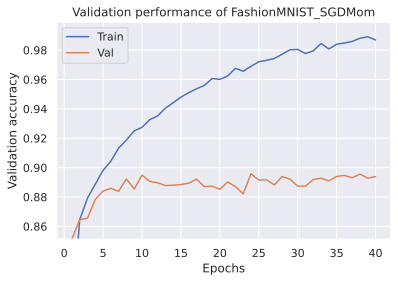

============= Test accuracy: 88.85% ==============



In [ ]:
SGDMom_model = copy.deepcopy(base_model).to(device)
SGDMom_results = train_model(SGDMom_model, "FashionMNIST_SGDMom", 
                             lambda params: SGDMomentum(params, lr=1e-1, momentum=0.9), 
                             max_epochs=40, batch_size=256)

  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  1] Training accuracy: 82.26%, Validation accuracy: 85.83%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  2] Training accuracy: 87.19%, Validation accuracy: 87.20%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  3] Training accuracy: 88.54%, Validation accuracy: 88.17%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  4] Training accuracy: 89.23%, Validation accuracy: 88.04%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  5] Training accuracy: 90.18%, Validation accuracy: 88.41%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  6] Training accuracy: 90.68%, Validation accuracy: 88.42%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  7] Training accuracy: 91.19%, Validation accuracy: 88.88%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  8] Training accuracy: 91.56%, Validation accuracy: 88.90%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  9] Training accuracy: 92.01%, Validation accuracy: 88.94%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 10] Training accuracy: 92.68%, Validation accuracy: 89.07%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 11] Training accuracy: 92.96%, Validation accuracy: 89.18%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 12] Training accuracy: 93.33%, Validation accuracy: 89.17%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 13] Training accuracy: 93.69%, Validation accuracy: 89.24%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 14] Training accuracy: 93.86%, Validation accuracy: 89.15%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 15] Training accuracy: 94.34%, Validation accuracy: 89.44%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 16] Training accuracy: 94.51%, Validation accuracy: 88.98%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 17] Training accuracy: 94.76%, Validation accuracy: 89.20%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 18] Training accuracy: 95.03%, Validation accuracy: 88.93%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 19] Training accuracy: 95.21%, Validation accuracy: 89.48%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 20] Training accuracy: 95.41%, Validation accuracy: 89.31%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 21] Training accuracy: 95.58%, Validation accuracy: 88.62%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 22] Training accuracy: 95.96%, Validation accuracy: 89.04%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 23] Training accuracy: 96.11%, Validation accuracy: 89.40%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 24] Training accuracy: 96.19%, Validation accuracy: 89.61%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 25] Training accuracy: 96.23%, Validation accuracy: 89.37%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 26] Training accuracy: 96.58%, Validation accuracy: 89.06%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 27] Training accuracy: 96.67%, Validation accuracy: 89.70%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 28] Training accuracy: 96.76%, Validation accuracy: 88.53%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 29] Training accuracy: 96.94%, Validation accuracy: 88.98%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 30] Training accuracy: 96.93%, Validation accuracy: 89.16%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 31] Training accuracy: 97.21%, Validation accuracy: 89.22%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 32] Training accuracy: 97.10%, Validation accuracy: 89.69%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 33] Training accuracy: 97.24%, Validation accuracy: 88.98%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 34] Training accuracy: 97.48%, Validation accuracy: 89.41%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 35] Training accuracy: 97.60%, Validation accuracy: 89.47%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 36] Training accuracy: 97.36%, Validation accuracy: 89.46%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 37] Training accuracy: 97.65%, Validation accuracy: 88.99%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 38] Training accuracy: 97.80%, Validation accuracy: 89.92%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 39] Training accuracy: 98.09%, Validation accuracy: 89.27%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 40] Training accuracy: 97.82%, Validation accuracy: 89.25%


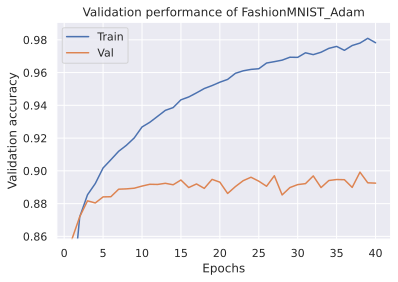

============= Test accuracy: 89.28% ==============



In [ ]:
Adam_model = copy.deepcopy(base_model).to(device)
Adam_results = train_model(Adam_model, "FashionMNIST_Adam", 
                           lambda params: Adam(params, lr=1e-3), 
                           max_epochs=40, batch_size=256)

結果、すべてのオプティマイザーは、指定されたモデルでも同様に適切に機能します。差が小さすぎて、重要な結論を見つけることができませんが、ただし、これは適用した初期化にも起因している可能性があります。初期化を、より悪い方向に変更しても、Adam は通常、その適応学習率により、より堅牢に学習してくれることを示しています。オプティマイザーの具体的な利点を示すために、モメンタムと適応学習率が重要となる背景損をいくつか見ていきます。

### Section2-2. 「溝」
異常な曲率は、峡谷に似た「溝」のタイプであり、単純な SGD 最適化では特に注意が必要です。言い換えれば、異常な曲率は通常、中心に最適値がある一方向に急な勾配を持ち、2 番目の方向では (全体的な) 最適値に向かって緩やかな勾配を持ちます。まずは、可視化してみましょう。

In [ ]:
def pathological_curve_loss(w1, w2):
    # パラメータを自由に変えてみてください
    x1_loss = torch.tanh(w1)**2 + 0.01 * torch.abs(w1)
    x2_loss = torch.sigmoid(w2)
    return x1_loss + x2_loss

In [ ]:
import matplotlib.cm as cm

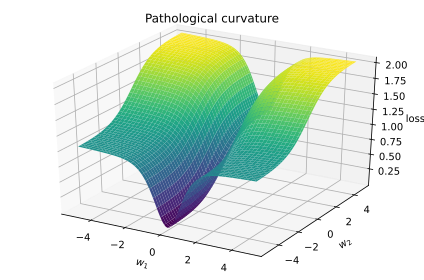

In [ ]:
def plot_curve(curve_fn, x_range=(-5,5), y_range=(-5,5), plot_3d=False, cmap=cm.viridis, title="Pathological curvature"):
    fig = plt.figure()
    ax = plt.axes(projection='3d') if plot_3d else plt.axes()
    
    x = torch.arange(x_range[0], x_range[1], (x_range[1]-x_range[0])/100.)
    y = torch.arange(y_range[0], y_range[1], (y_range[1]-y_range[0])/100.)
    x, y = torch.meshgrid(x, y, indexing='xy')
    z = curve_fn(x, y)
    x, y, z = x.numpy(), y.numpy(), z.numpy()
    
    if plot_3d:
        ax.plot_surface(x, y, z, cmap=cmap, linewidth=1, color="#000", antialiased=False)
        ax.set_zlabel("loss")
    else:
        ax.imshow(z[::-1], cmap=cmap, extent=(x_range[0], x_range[1], y_range[0], y_range[1]))
    plt.title(title)
    ax.set_xlabel(r"$w_1$")
    ax.set_ylabel(r"$w_2$")
    plt.tight_layout()
    return ax

sns.reset_orig()
_ = plot_curve(pathological_curve_loss, plot_3d=True)
plt.show()

最適化に関しては、および は重みパラメーターであり、曲率は空間上の損失を表します。典型的なネットワークでは、2 つよりもはるかに多くのパラメーターがあり、そのような曲率は多次元空間でも発生する可能性があることに注意してください。

理想的には、私たちの最適化アルゴリズムは峡谷の中心を見つけ、その方向に向かってパラメーターを最適化することに焦点を当てます。ただし、尾根に沿った点に遭遇すると、勾配ははるかに大きくなります。
勾配が大きいため、学習率を下げる必要があり、学習が大幅に遅くなります。

In [ ]:
def train_curve(optimizer_func, curve_func=pathological_curve_loss, num_updates=100, init=[5,5]):
    """
    Inputs:
        optimizer_func - 使用するオプティマイザーのコンストラクター。パラメータリストのみを受け取る必要あり
        curve_func - 損失関数
        num_updates - 最適化時に実行する更新/手順の数 
        init - パラメータの初期値。 w_1 と w_2 を表す 2 つの要素を持つリスト/タプルでなければなりません
    Outputs:
        [t,:2] はステップ t でのパラメーター値、[t,2] は t での損失
    """
    weights = nn.Parameter(torch.FloatTensor(init), requires_grad=True)
    optimizer = optimizer_func([weights])
    
    list_points = []
    for _ in range(num_updates):
        loss = curve_func(weights[0], weights[1])
        list_points.append(torch.cat([weights.data.detach(), loss.unsqueeze(dim=0).detach()], dim=0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    points = torch.stack(list_points, dim=0).numpy()
    return points

次に、曲率にさまざまなオプティマイザーを適用しましょう。標準的なニューラル ネットワークの場合と同様に、最適化アルゴリズムの学習率をはるかに高く設定していることに注意してください。これは、数万または数百万ではなく、2 つのパラメーターしかないためです。

In [ ]:
SGD_points = train_curve(lambda params: SGD(params, lr=10))
SGDMom_points = train_curve(lambda params: SGDMomentum(params, lr=10, momentum=0.9))
Adam_points = train_curve(lambda params: Adam(params, lr=1))

さまざまなアルゴリズムがどのように機能したかを最もよく理解するために、更新ステップを損失面を通る線プロットとして可視化します。見やすくするために、2D 表現にします

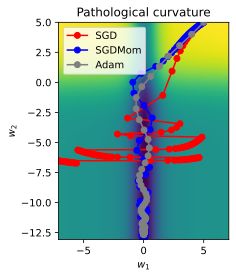

In [ ]:
all_points = np.concatenate([SGD_points, SGDMom_points, Adam_points], axis=0)
ax = plot_curve(pathological_curve_loss,
                x_range=(-np.absolute(all_points[:,0]).max(), np.absolute(all_points[:,0]).max()),
                y_range=(all_points[:,1].min(), all_points[:,1].max()),
                plot_3d=False)
ax.plot(SGD_points[:,0], SGD_points[:,1], color="red", marker="o", zorder=1, label="SGD")
ax.plot(SGDMom_points[:,0], SGDMom_points[:,1], color="blue", marker="o", zorder=2, label="SGDMom")
ax.plot(Adam_points[:,0], Adam_points[:,1], color="grey", marker="o", zorder=3, label="Adam")
plt.legend()
plt.show()

SGD が最適化曲線の中心を見つけることができず、勾配が急であるために収束に問題があることがはっきりとわかります。一方、Adamは比較的、急峻な勾配をうまく避けているように見えます。

#### 急な最適
損失の 2番目のタイプは、急勾配の最適値です。それらでは、非常に小さな勾配を持つ表面の大部分がありますが、最適な場所では非常に大きな勾配があります。たとえば、次の損失曲面を取り上げます。

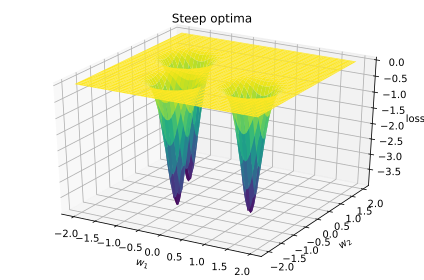

In [ ]:
def bivar_gaussian(w1, w2, x_mean=0.0, y_mean=0.0, x_sig=1.0, y_sig=1.0):
    norm = 1 / (2 * np.pi * x_sig * y_sig)
    x_exp = (-1 * (w1 - x_mean)**2) / (2 * x_sig**2)
    y_exp = (-1 * (w2 - y_mean)**2) / (2 * y_sig**2)
    return norm * torch.exp(x_exp + y_exp)

def comb_func(w1, w2):
    z = -bivar_gaussian(w1, w2, x_mean=1.0, y_mean=-0.5, x_sig=0.2, y_sig=0.2)
    z -= bivar_gaussian(w1, w2, x_mean=-1.0, y_mean=0.5, x_sig=0.2, y_sig=0.2)
    z -= bivar_gaussian(w1, w2, x_mean=-0.5, y_mean=-0.8, x_sig=0.2, y_sig=0.2)
    return z

_ = plot_curve(comb_func, x_range=(-2,2), y_range=(-2,2), plot_3d=True, title="Steep optima")

損失曲面の大部分には、勾配がほとんどまたはまったくありません。ただし、最適値に近づくと、勾配が非常に急になります。勾配の低い領域で開始するときに最小値に到達するには、適応学習率が重要であると予想されます。この仮説を検証するために、3つのオプティマイザーを実行します。

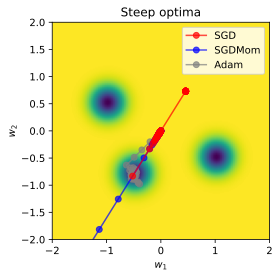

In [ ]:
SGD_points = train_curve(lambda params: SGD(params, lr=.5), comb_func, init=[0,0])
SGDMom_points = train_curve(lambda params: SGDMomentum(params, lr=1, momentum=0.9), comb_func, init=[0,0])
Adam_points = train_curve(lambda params: Adam(params, lr=0.2), comb_func, init=[0,0])

all_points = np.concatenate([SGD_points, SGDMom_points, Adam_points], axis=0)
ax = plot_curve(comb_func,
                x_range=(-2, 2),
                y_range=(-2, 2),
                plot_3d=False,
                title="Steep optima")
ax.plot(SGD_points[:,0], SGD_points[:,1], color="red", marker="o", zorder=3, label="SGD", alpha=0.7)
ax.plot(SGDMom_points[:,0], SGDMom_points[:,1], color="blue", marker="o", zorder=2, label="SGDMom", alpha=0.7)
ax.plot(Adam_points[:,0], Adam_points[:,1], color="grey", marker="o", zorder=1, label="Adam", alpha=0.7)
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
plt.legend()
plt.show()

SGD は、最適の境界に達するまで、最初は非常に小さなステップを踏んでいきます。  
最初に周囲の点に到達すると勾配の方向が変更され、パラメーターが変化します。そこから SGD はもう回復できません (非常に多くのステップがある場合のみ)。  
Adam は適応学習率の重要性を示す最適値に収束することができます。